In [1]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os




In [2]:

train_dir = 'C:/work/Cyclone/Train'  
test_dir = 'C:/work/Cyclone/Test'  


train_datagen = ImageDataGenerator(
    rescale=1./255,          
    shear_range=0.2,        
    zoom_range=0.2,         
    horizontal_flip=True)    

test_datagen = ImageDataGenerator(rescale=1./255)  

# Load the training and testing datasets from directory
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  
    batch_size=32,           
    class_mode='categorical'  
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Found 10000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [3]:

base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
num_classes = 2  
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)


In [4]:

for layer in base_model.layers:
    layer.trainable = False



In [5]:

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])



In [6]:

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_mobilenet_model.keras', monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

callbacks = [early_stopping, checkpoint, reduce_lr]


In [7]:

history = model.fit(
    train_data,
    epochs=10,  
    validation_data=test_data,
    callbacks=callbacks
)


Epoch 1/10


c:\Users\suman\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


313/313 ━━━━━━━━━━━━━━━━━━━━ 295s 923ms/step - accuracy: 0.8603 - loss: 0.3153 - val_accuracy: 0.9415 - val_loss: 0.1631 - learning_rate: 1.0000e-04
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 209s 664ms/step - accuracy: 0.9438 - loss: 0.1460 - val_accuracy: 0.9515 - val_loss: 0.1338 - learning_rate: 1.0000e-04
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 210s 667ms/step - accuracy: 0.9541 - loss: 0.1227 - val_accuracy: 0.9290 - val_loss: 0.1877 - learning_rate: 1.0000e-04
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 209s 662ms/step - accuracy: 0.9542 - loss: 0.1230 - val_accuracy: 0.9545 - val_loss: 0.1299 - learning_rate: 1.0000e-04
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 208s 661ms/step - accuracy: 0.9581 - loss: 0.1075 - val_accuracy: 0.9640 - val_loss: 0.1048 - learning_rate: 1.0000e-04
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 209s 661ms/step - accuracy: 0.9624 - loss: 0.0976 - val_accuracy: 0.9670 - val_loss: 0.0997 - learning_rate: 1.0000e-04
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 209s 663ms/

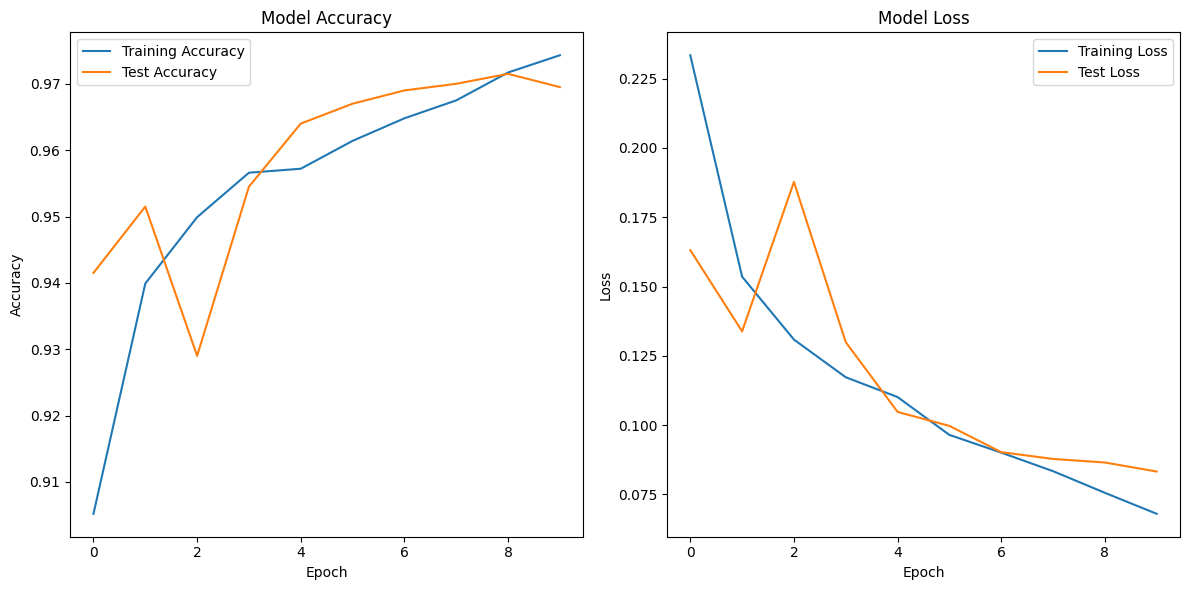

In [8]:
import matplotlib.pyplot as plt

# Function to plot accuracy and loss graphs
def plot_training_history(history):
    plt.figure(figsize=(12, 6))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Test Accuracy')  
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')  
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    
    plt.tight_layout()  
    plt.show()


plot_training_history(history)


In [9]:
# Load the trained model
model = tf.keras.models.load_model('best_mobilenet_model.keras')  


In [10]:
from tensorflow.keras.preprocessing import image
import numpy as np

def load_and_preprocess_image(img_path):
    # Load the image
    img = image.load_img(img_path, target_size=(224, 224))  
    img_array = image.img_to_array(img)  
    img_array = np.expand_dims(img_array, axis=0)  
    img_array /= 255.0  
    return img_array


In [23]:
def predict_image(img_path):
    
    img_array = load_and_preprocess_image(img_path)
    
    
    prediction = model.predict(img_array)
    
    
    if prediction[0][0] > 0.5:  
        return "Damaged"
    else:
        return "Not Damaged"

img_path = 'C:/work/Cyclone/Test/no_damage/-95.6263_29.862038000000002.jpeg'  
result = predict_image(img_path)
print(f'The image is: {result}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
The image is: Not Damaged


In [14]:
pip install tensorflow opencv-python numpy


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [15]:
import tensorflow as tf

# Load your pre-trained model
model = tf.keras.models.load_model('C:/work/Cyclone/Train/best_mobilenet_model.keras')


In [16]:
import cv2
import numpy as np

def preprocess_image(image_path):
    # Load the image
    image = cv2.imread(image_path)
    # Resize the image to the input size of your model
    image = cv2.resize(image, (224, 224))  # Adjust size as necessary
    # Normalize the image
    image = image / 255.0
    # Expand dimensions to match model input shape
    image = np.expand_dims(image, axis=0)
    return image


In [20]:
def predict_damage(image_path):
    # Preprocess the image
    image = preprocess_image(image_path)
    
    # Make a prediction
    prediction = model.predict(image)
    
    # Assuming binary classification with a threshold of 0.5
    damage_score = prediction[0][0]  # Get the damage score
    
    # Convert score to percentage
    damage_percentage = damage_score * 100
    
    return damage_percentage

# Example usage
image_path = 'C:/work/Cyclone/Train/no_damage/-95.0945_29.833643.jpeg'
damage_percentage = predict_damage(image_path)
print(f'Damage Percentage: {damage_percentage:.2f}%')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Damage Percentage: 0.03%
